In [78]:
import pandas as pd
import numpy as np

# Reproducibility
rng = np.random.default_rng(42)
n = 500  # number of trees

# Variables
tree_height = rng.normal(20, 8, n).clip(5, 60)  # meters
leaf_size = rng.choice(["small", "medium", "large"], size=n, p=[0.4, 0.4, 0.2])
soil_quality = rng.integers(1, 11, n)  # 1–10 scale
rainfall = rng.normal(1500, 400, n).clip(500, 3000)  # annual mm
sunlight = rng.normal(8, 2, n).clip(2, 12)  # hours/day
has_fruit = rng.integers(0, 2, n)
is_conifer = rng.integers(0, 2, n)
forest_density = rng.normal(150, 60, n).clip(50, 400)  # trees per hectare
tree_age = rng.integers(1, 201, n)  # years

# Survival probability (nonlinear with interactions)
prob_survive = (
    0.3 * (soil_quality / 10)
    + 0.2 * ((sunlight > 6) & (sunlight < 10))
    + 0.2 * ((rainfall > 1000) & (rainfall < 2000))
    + 0.1 * is_conifer
    - 0.1 * (forest_density > 200)
    + rng.normal(0, 0.1, n)  # noise
)

# Convert to 0/1 target
survival = (prob_survive > 0.5).astype(int)

# DataFrame
df = pd.DataFrame({
    "Tree_Height_m": tree_height.round(1),
    "Leaf_Size": leaf_size,
    "Soil_Quality": soil_quality,
    "Rainfall_mm": rainfall.round(0),
    "Sunlight_Hours": sunlight.round(1),
    "Has_Fruit": has_fruit,
    "Is_Conifer": is_conifer,
    "Forest_Density": forest_density.round(0),
    "Tree_Age": tree_age,
    "Survival_in_Forest": survival
})

# Save to CSV
df.to_csv("synthetic_trees_forest.csv", index=False)
print("Saved synthetic_trees_forest.csv with shape:", df.shape)

Saved synthetic_trees_forest.csv with shape: (500, 10)


In [79]:
import matplotlib.pyplot as plt

import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [80]:
# Just a visual unification
from statsmodels.graphics.gofplots import ProbPlot

import plotly.express as px

custom_palette = ['#d01c8b', '#4dac26']  # pink to green

# Seaborn defaults
sns.set_palette(custom_palette)
sns.set_style("whitegrid")  # Optional styling

#  Matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette)

# Plotly defaults
px.defaults.color_discrete_sequence = custom_palette

# Optional case I use seaborn.color_palette("PiYG") elsewhere
piyg_palette = sns.color_palette("PiYG", 7).as_hex()


from matplotlib.colors import LinearSegmentedColormap

bubblegum_pistachio_cmap = LinearSegmentedColormap.from_list(
    name='bubblegum_pistachio',
    colors=['#d01c8b', '#f2b4d4', '#d9f0d3', '#4dac26']
)

In [81]:
df.head()

,Tree_Height_m,Leaf_Size,Soil_Quality,Rainfall_mm,Sunlight_Hours,Has_Fruit,Is_Conifer,Forest_Density,Tree_Age,Survival_in_Forest
0,22.4,small,8,1535.0,5.1,1,1,227.0,75,0
1,11.7,small,8,1631.0,7.0,1,0,50.0,152,1
2,26.0,medium,3,1183.0,9.8,0,0,161.0,192,1
3,27.5,small,10,1511.0,5.3,0,1,115.0,100,0
4,5.0,small,5,1728.0,7.6,1,1,128.0,173,1


In [82]:
# Building a decision tree model
# Separating the target variable and other variables

# Get dummies
df = pd.get_dummies(data = df, columns = ['Leaf_Size'])

Y = df.Survival_in_Forest

X = df.drop(['Survival_in_Forest'], axis = 1)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tree_Height_m       500 non-null    float64
 1   Soil_Quality        500 non-null    int64  
 2   Rainfall_mm         500 non-null    float64
 3   Sunlight_Hours      500 non-null    float64
 4   Has_Fruit           500 non-null    int64  
 5   Is_Conifer          500 non-null    int64  
 6   Forest_Density      500 non-null    float64
 7   Tree_Age            500 non-null    int64  
 8   Survival_in_Forest  500 non-null    int64  
 9   Leaf_Size_large     500 non-null    bool   
 10  Leaf_Size_medium    500 non-null    bool   
 11  Leaf_Size_small     500 non-null    bool   
dtypes: bool(3), float64(4), int64(5)
memory usage: 36.8 KB


In [84]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 90210)
# Building decision tree model
dt = DecisionTreeClassifier(class_weight="balanced", random_state=90210)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=90210)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       170

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00      1.00      1.00       350



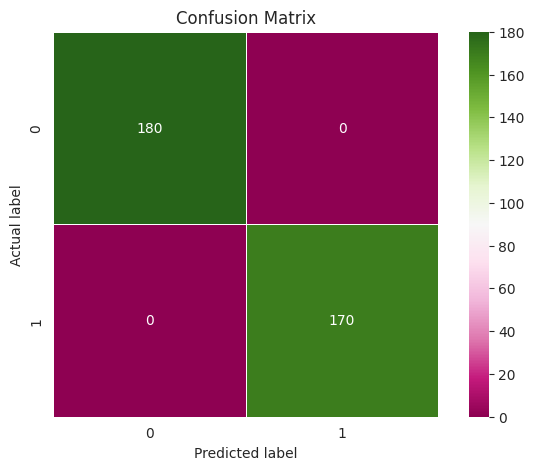

In [85]:
# Checking performance on the training dataset
y_train_pred_dt = dt.predict(X_train)
def metrics_score(actual, predicted):
   print(classification_report(actual, predicted))
   cm = confusion_matrix(actual, predicted)
   plt.figure(figsize = (8, 5))
   sns.heatmap(cm, annot = True, fmt = ".0f", linewidths = 0.5, square = True, cmap = "PiYG")
   plt.ylabel("Actual label")
   plt.xlabel("Predicted label")
   plt.title("Confusion Matrix")
   plt.show()
metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63        68
           1       0.69      0.71      0.70        82

    accuracy                           0.67       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.67      0.67      0.67       150



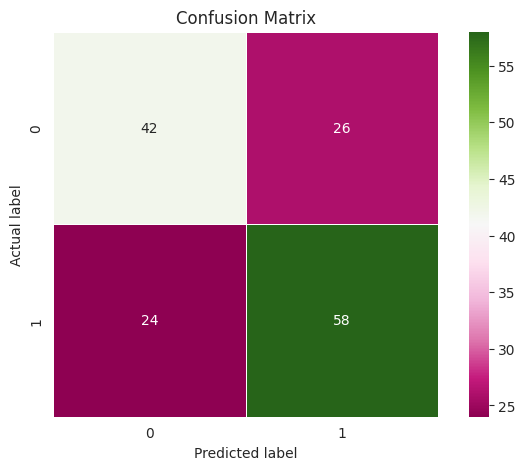

In [86]:
y_test_pred_dt = dt.predict(X_test)

metrics_score(y_test, y_test_pred_dt)

In [87]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable

    Adapted from MIT ADSP
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # Compute recall

    precision = precision_score(target, pred, average = 'macro')          # Compute precision

    acc = accuracy_score(target, pred)                                    # Compute accuracy score


    # Creating a dataframe of metrics

    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },

        index = [0],
    )

    return df_perf

In [88]:
dtree_test = model_performance_classification(dt,X_test,y_test)
dtree_test

,Precision,Recall,Accuracy
0,0.66342,0.662482,0.666667


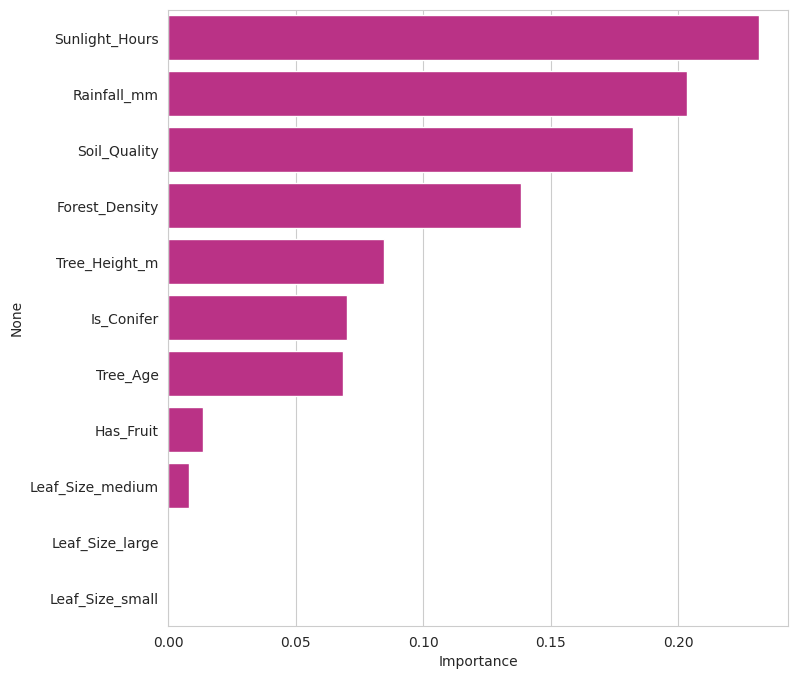

In [89]:
# Plot the feature importance

importances = dt.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (8, 8))

sns.barplot(x=importance_df.Importance,y=importance_df.index);

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred_train = dtree_estimator.predict(X_train)
y_pred_test  = dtree_estimator.predict(X_test)

# Probabilities (for AUC, if relevant)
y_proba_train = dtree_estimator.predict_proba(X_train)[:, 1]
y_proba_test  = dtree_estimator.predict_proba(X_test)[:, 1]

In [91]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(class_weight = 'balanced', random_state = 90210)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 8),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25, 30],
              'min_samples_split': [2, 5, 10, 15, 20]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 5)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(X_train, y_train)

# ---- Train Metrics ----
print("*** TRAIN REPORT ***")
print(classification_report(y_train, y_pred_train, target_names=["Dead","Survive"]))
print("TRAIN Confusion:\n", confusion_matrix(y_train, y_pred_train))
print("TRAIN ROC-AUC:", roc_auc_score(y_train, y_proba_train).round(3))

# ---- Test Metrics ----
print("\n*** TEST REPORT ***")
print(classification_report(y_test, y_pred_test, target_names=["Dead","Survive"]))
print("TEST Confusion:\n", confusion_matrix(y_test, y_pred_test))
print("TEST ROC-AUC:", roc_auc_score(y_test, y_proba_test).round(3))




*** TRAIN REPORT ***
              precision    recall  f1-score   support

        Dead       0.87      0.86      0.86       180
     Survive       0.85      0.86      0.86       170

    accuracy                           0.86       350
   macro avg       0.86      0.86      0.86       350
weighted avg       0.86      0.86      0.86       350

TRAIN Confusion:
 [[155  25]
 [ 24 146]]
TRAIN ROC-AUC: 0.93

*** TEST REPORT ***
              precision    recall  f1-score   support

        Dead       0.65      0.69      0.67        68
     Survive       0.73      0.70      0.71        82

    accuracy                           0.69       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.70      0.69      0.69       150

TEST Confusion:
 [[47 21]
 [25 57]]
TEST ROC-AUC: 0.763


              precision    recall  f1-score   support

           0       0.87      0.86      0.86       180
           1       0.85      0.86      0.86       170

    accuracy                           0.86       350
   macro avg       0.86      0.86      0.86       350
weighted avg       0.86      0.86      0.86       350



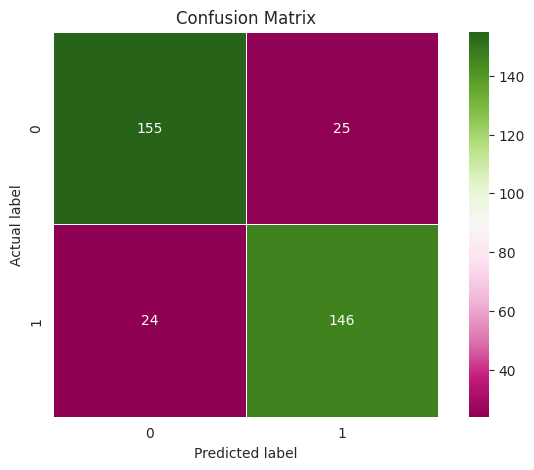

In [92]:
# Checking performance on the training dataset
y_train_pred_dt = dtree_estimator.predict(X_train)

metrics_score(y_train, y_train_pred_dt)

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred_train = dtree_estimator.predict(X_train)
y_pred_test  = dtree_estimator.predict(X_test)

# Probabilities (for AUC, if relevant)
y_proba_train = dtree_estimator.predict_proba(X_train)[:, 1]
y_proba_test  = dtree_estimator.predict_proba(X_test)[:, 1]

# *** Train Metrics ***
print("*** TRAIN REPORT ***")
print(classification_report(y_train, y_pred_train, target_names=["Dead","Survive"]))
print("TRAIN Confusion:\n", confusion_matrix(y_train, y_pred_train))
print("TRAIN ROC-AUC:", roc_auc_score(y_train, y_proba_train).round(3))

# *** Test Metrics ***
print("\n*** TEST REPORT ***")
print(classification_report(y_test, y_pred_test, target_names=["Dead","Survive"]))
print("TEST Confusion:\n", confusion_matrix(y_test, y_pred_test))
print("TEST ROC-AUC:", roc_auc_score(y_test, y_proba_test).round(3))

*** TRAIN REPORT ***
              precision    recall  f1-score   support

        Dead       0.87      0.86      0.86       180
     Survive       0.85      0.86      0.86       170

    accuracy                           0.86       350
   macro avg       0.86      0.86      0.86       350
weighted avg       0.86      0.86      0.86       350

TRAIN Confusion:
 [[155  25]
 [ 24 146]]
TRAIN ROC-AUC: 0.93

*** TEST REPORT ***
              precision    recall  f1-score   support

        Dead       0.65      0.69      0.67        68
     Survive       0.73      0.70      0.71        82

    accuracy                           0.69       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.70      0.69      0.69       150

TEST Confusion:
 [[47 21]
 [25 57]]
TEST ROC-AUC: 0.763


In [94]:
dtree_tuned_test = model_performance_classification(dtree_estimator,X_test,y_test)
dtree_tuned_test

,Precision,Recall,Accuracy
0,0.691774,0.693149,0.693333


In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1) Get the effective alphas for cost-complexity pruning
#     cost_complexity_pruning_path() gives back possible values of ccp_alpha
#     each alpha corresponds to pruning away some branches
path = dt.cost_complexity_pruning_path(X, Y)

# 2) Sample 25 possible pruning strengths (ccp_alpha values)
#    between the smallest and largest suggested by the path
alphas = np.linspace(path.ccp_alphas.min(), path.ccp_alphas.max(), 25)

scores = []
for a in alphas:
    # 3) For each alpha, train a pruned decision tree
    #     ccp_alpha controls the pruning penalty
    #     min_samples_leaf=5 ensures leaves have at least 5 samples
    m = DecisionTreeClassifier(
        random_state=90210,
        ccp_alpha=a,
        min_samples_leaf=5
    )

# 4) Evaluate the model with 5-fold cross-validation using F1-score
    scores.append(cross_val_score(m, X, Y, cv=5, scoring="f1").mean())

# 5) Select the alpha that produced the best average cross-validated F1 score
best_alpha = alphas[int(np.argmax(scores))]

# 6) Train the final pruned decision tree with the chosen alpha
dt_pruned = DecisionTreeClassifier(
    random_state=90210,
    ccp_alpha=best_alpha,
    min_samples_leaf=5
).fit(X, Y)

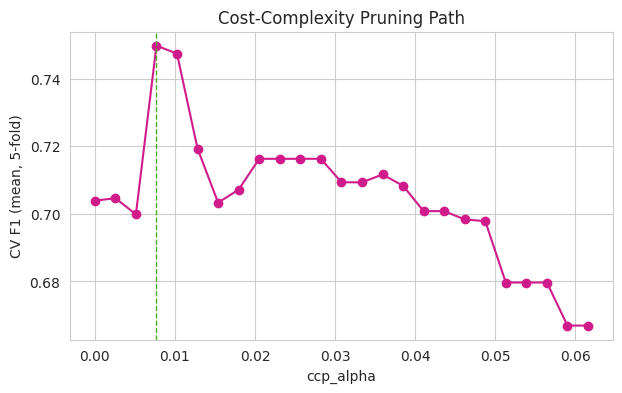

Best alpha: 0.00769647019647024


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# 1) Get the effective alphas for cost-complexity pruning
#     cost_complexity_pruning_path() gives back possible values of ccp_alpha
#     each alpha corresponds to pruning away some branches

path = dt.cost_complexity_pruning_path(X, Y)

# 2) Sample 25 possible pruning strengths (ccp_alpha values)
#    between the smallest and largest suggested by the path
alphas = np.linspace(path.ccp_alphas.min(), path.ccp_alphas.max(), 25)

scores = []
for a in alphas:
# 3) For each alpha, train a pruned decision tree
#     ccp_alpha controls the pruning penalty
#     min_samples_leaf=5 ensures leaves have at least 5 samples
    m = DecisionTreeClassifier(random_state=90210, ccp_alpha=a, min_samples_leaf=5)
    s = cross_val_score(m, X, Y, cv=5, scoring="f1")

# 4) Evaluate the model with 5-fold cross-validation using F1-score
    scores.append(s.mean())

# 5) Select the alpha that produced the best average cross-validated F1 score
best_alpha = alphas[np.argmax(scores)]

# 6) Train the final pruned decision tree with the chosen alpha
dt_pruned = DecisionTreeClassifier(
    random_state=90210,
    ccp_alpha=best_alpha,
    min_samples_leaf=5
).fit(X, Y)

# Plot Cost-Complexity Pruning Path

plt.figure(figsize=(7,4))
plt.plot(alphas, scores, marker="o")
plt.axvline(best_alpha, ls="--", lw=1, color = '#4dac26')
plt.xlabel("ccp_alpha")
plt.ylabel("CV F1 (mean, 5-fold)")
plt.title("Cost-Complexity Pruning Path")
plt.show()
print("Best alpha:", best_alpha)

In [97]:
from sklearn.model_selection import cross_validate

best_model = DecisionTreeClassifier(random_state=7, ccp_alpha=best_alpha, min_samples_leaf=5)
cv = 5
cv_results = cross_validate(
    best_model, X, Y, cv=cv,
    scoring=["accuracy","precision","recall","f1","roc_auc"],
    return_train_score=False
)

for m in ["test_accuracy","test_precision","test_recall","test_f1","test_roc_auc"]:
    print(f"{m.replace('test_','').upper()}: {cv_results[m].mean():.3f} (+/- {cv_results[m].std():.3f})")


ACCURACY: 0.744 (+/- 0.034)
PRECISION: 0.747 (+/- 0.056)
RECALL: 0.762 (+/- 0.068)
F1: 0.750 (+/- 0.028)
ROC_AUC: 0.814 (+/- 0.018)


              precision    recall  f1-score   support

        Dead       0.79      0.66      0.72        74
     Survive       0.72      0.83      0.77        76

    accuracy                           0.75       150
   macro avg       0.75      0.75      0.74       150
weighted avg       0.75      0.75      0.74       150

Confusion matrix:
 [[49 25]
 [13 63]]


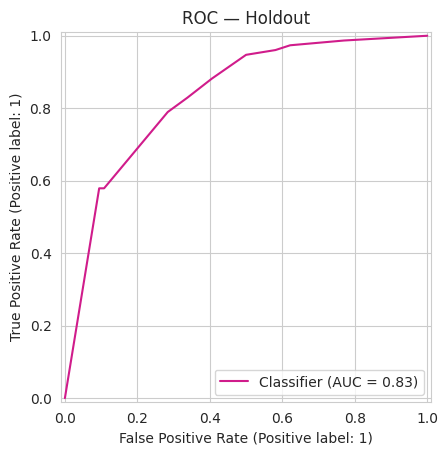

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.3, random_state=7, stratify=Y)

final_model = DecisionTreeClassifier(random_state=7, ccp_alpha=best_alpha, min_samples_leaf=5)
final_model.fit(X_tr, y_tr)

y_pred = final_model.predict(X_te)
y_proba = final_model.predict_proba(X_te)[:,1]

print(classification_report(y_te, y_pred, target_names=["Dead","Survive"]))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))

RocCurveDisplay.from_predictions(y_te, y_proba)
plt.title("ROC — Holdout")
plt.show()

In [99]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=7, stratify=Y
)

# 2) Get pruning alphas on TRAIN ONLY
tmp = DecisionTreeClassifier(random_state=90210).cost_complexity_pruning_path(X_train, y_train)
alphas = np.linspace(tmp.ccp_alphas.min(), tmp.ccp_alphas.max(), 25)

# 3) Pick best alpha by CV (on TRAIN)
cv_scores = []
for a in alphas:
    m = DecisionTreeClassifier(random_state=7, ccp_alpha=a, min_samples_leaf=5)
    s = cross_val_score(m, X_train, y_train, cv=5, scoring="f1").mean()
    cv_scores.append(s)

best_alpha = alphas[int(np.argmax(cv_scores))]
print(f"Best alpha (CV on train): {best_alpha:.6f}")

Best alpha (CV on train): 0.010975


*** TRAIN REPORT ***
              precision    recall  f1-score   support

        Dead       0.85      0.72      0.78       174
     Survive       0.76      0.88      0.81       176

    accuracy                           0.80       350
   macro avg       0.81      0.80      0.80       350
weighted avg       0.81      0.80      0.80       350

TRAIN Confusion:
 [[126  48]
 [ 22 154]]

*** TEST REPORT ***
              precision    recall  f1-score   support

        Dead       0.79      0.59      0.68        74
     Survive       0.68      0.84      0.75        76

    accuracy                           0.72       150
   macro avg       0.73      0.72      0.71       150
weighted avg       0.73      0.72      0.72       150

TEST Confusion:
 [[44 30]
 [12 64]]


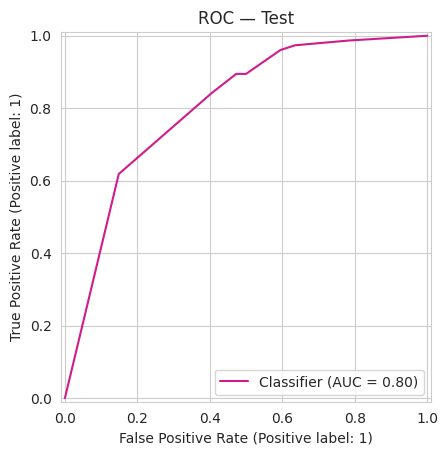

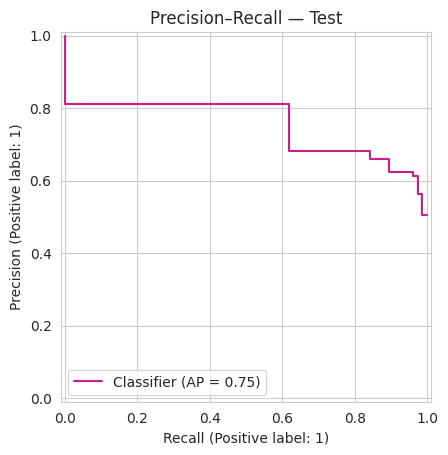

In [100]:
# 4) Fit final model on TRAIN
dt_pruned = DecisionTreeClassifier(random_state=7, ccp_alpha=best_alpha, min_samples_leaf=5)
dt_pruned.fit(X_train, y_train)

# 5) Train metrics
y_pred_tr  = dt_pruned.predict(X_train)
print("*** TRAIN REPORT ***")
print(classification_report(y_train, y_pred_tr, target_names=["Dead","Survive"]))
print("TRAIN Confusion:\n", confusion_matrix(y_train, y_pred_tr))

# 6) Test metrics
y_pred_te  = dt_pruned.predict(X_test)
y_proba_te = dt_pruned.predict_proba(X_test)[:, 1]

print("\n*** TEST REPORT ***")
print(classification_report(y_test, y_pred_te, target_names=["Dead","Survive"]))
print("TEST Confusion:\n", confusion_matrix(y_test, y_pred_te))

# Optional curves for TEST
RocCurveDisplay.from_predictions(y_test, y_proba_te)
plt.title("ROC — Test")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_te)
plt.title("Precision–Recall — Test")
plt.show()

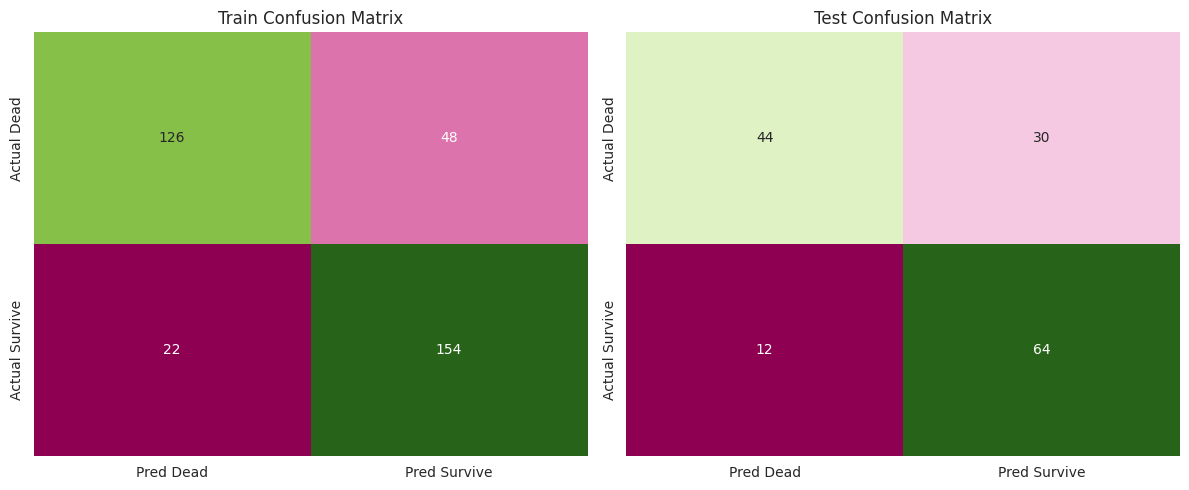

In [101]:
cm_train = confusion_matrix(y_train, y_pred_tr)
cm_test  = confusion_matrix(y_test,  y_pred_te)

# Side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="PiYG", cbar=False,
            xticklabels=["Pred Dead","Pred Survive"],
            yticklabels=["Actual Dead","Actual Survive"],
            ax=axes[0])
axes[0].set_title("Train Confusion Matrix")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="PiYG", cbar=False,
            xticklabels=["Pred Dead","Pred Survive"],
            yticklabels=["Actual Dead","Actual Survive"],
            ax=axes[1])
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

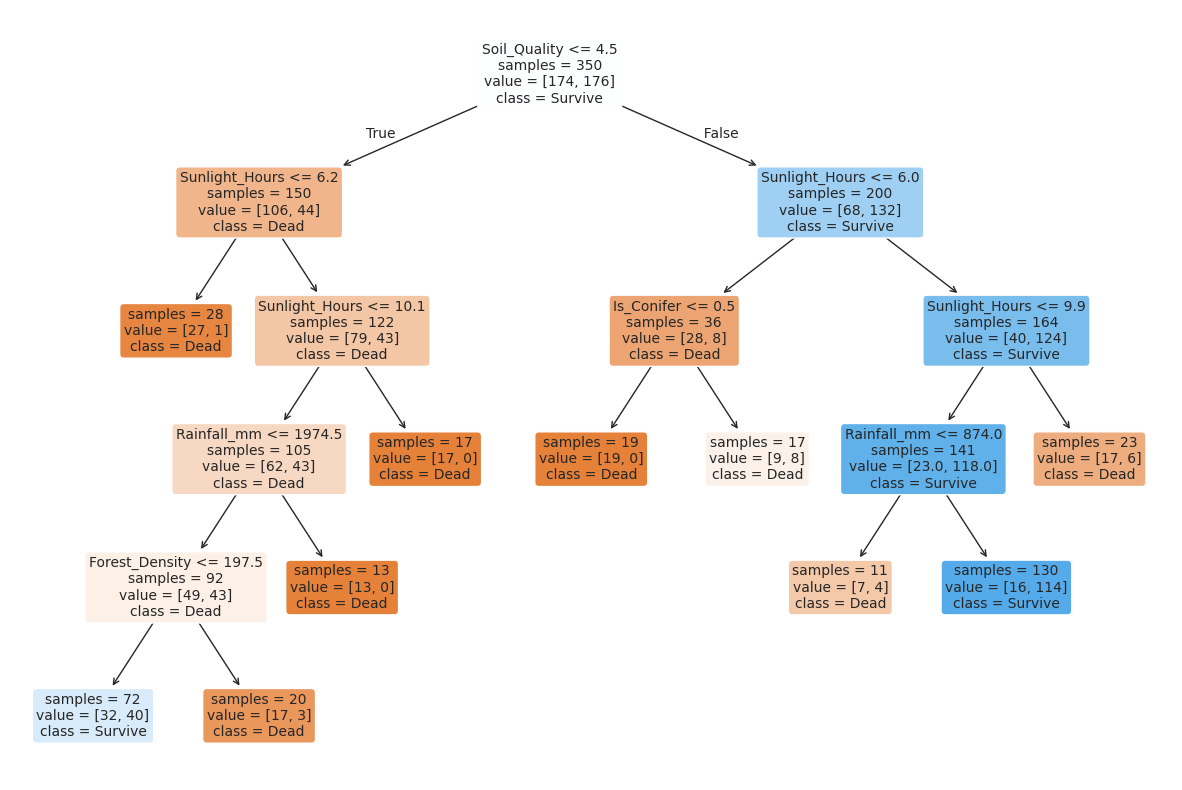

In [102]:
import matplotlib.pyplot as plt
from sklearn import tree

features = list(X.columns)

plt.figure(figsize=(15, 10))
tree.plot_tree(
    dt_pruned,
    feature_names=features,
    class_names=["Dead","Survive"],
    filled=True,
    rounded=True,             # rounded boxes
    impurity=False,           # no Gini/entropy score for vis
    proportion=False,         # raw counts (or True for %)
    precision=1,              # fewer decimals
    max_depth=6,              # cap depth to keep it readable
    fontsize=10
)
plt.show()

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, recall_score
)
import numpy as np

#  Estimator
rf_estimator = RandomForestClassifier(
    class_weight='balanced',
    random_state=90210,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True  # out-of-bag validation
)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=7, stratify=Y
)

# Grid of parameters
rf_params = {
    'n_estimators': [400, 600, 800], # Number of trees in the forest
    'max_depth': [6, 8, 10],         # How deep the tree can grow
    'min_samples_leaf': [3, 5, 10],  # Minimum number of samples per leaf
    'min_samples_split': [2, 5, 10], # Minimum number of samples per node in order to split
    'max_features': [2, 4, 6, 8]     # per-split feature subset
}

# coring (same idea: recall on class 1)
rf_scorer = metrics.make_scorer(recall_score, pos_label=1)

#  Grid search
rf_grid = GridSearchCV(
    rf_estimator,
    rf_params,
    scoring=rf_scorer,
    cv=5,
    n_jobs=-1,
    refit=True
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

#  Predictions/Probas
y_pred_train = rf_best.predict(X_train)
y_proba_train = rf_best.predict_proba(X_train)[:, 1]

y_pred_test  = rf_best.predict(X_test)
y_proba_test = rf_best.predict_proba(X_test)[:, 1]

#  Reports
print("*** BEST PARAMS ***")
print(rf_grid.best_params_)
if hasattr(rf_best, "oob_score_"):
    print("OOB score:", round(rf_best.oob_score_, 3))

print("\n*** TRAIN REPORT ***")
print(classification_report(y_train, y_pred_train, target_names=["Dead","Survive"]))
print("TRAIN Confusion:\n", confusion_matrix(y_train, y_pred_train))
print("TRAIN ROC-AUC:", roc_auc_score(y_train, y_proba_train).round(3))

print("\n*** TEST REPORT ***")
print(classification_report(y_test, y_pred_test, target_names=["Dead","Survive"]))
print("TEST Confusion:\n", confusion_matrix(y_test, y_pred_test))
print("TEST ROC-AUC:", roc_auc_score(y_test, y_proba_test).round(3))


*** BEST PARAMS ***
{'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 600}
OOB score: 0.763

*** TRAIN REPORT ***
              precision    recall  f1-score   support

        Dead       0.91      0.91      0.91       174
     Survive       0.91      0.91      0.91       176

    accuracy                           0.91       350
   macro avg       0.91      0.91      0.91       350
weighted avg       0.91      0.91      0.91       350

TRAIN Confusion:
 [[158  16]
 [ 16 160]]
TRAIN ROC-AUC: 0.985

*** TEST REPORT ***
              precision    recall  f1-score   support

        Dead       0.76      0.76      0.76        74
     Survive       0.76      0.76      0.76        76

    accuracy                           0.76       150
   macro avg       0.76      0.76      0.76       150
weighted avg       0.76      0.76      0.76       150

TEST Confusion:
 [[56 18]
 [18 58]]
TEST ROC-AUC: 0.87


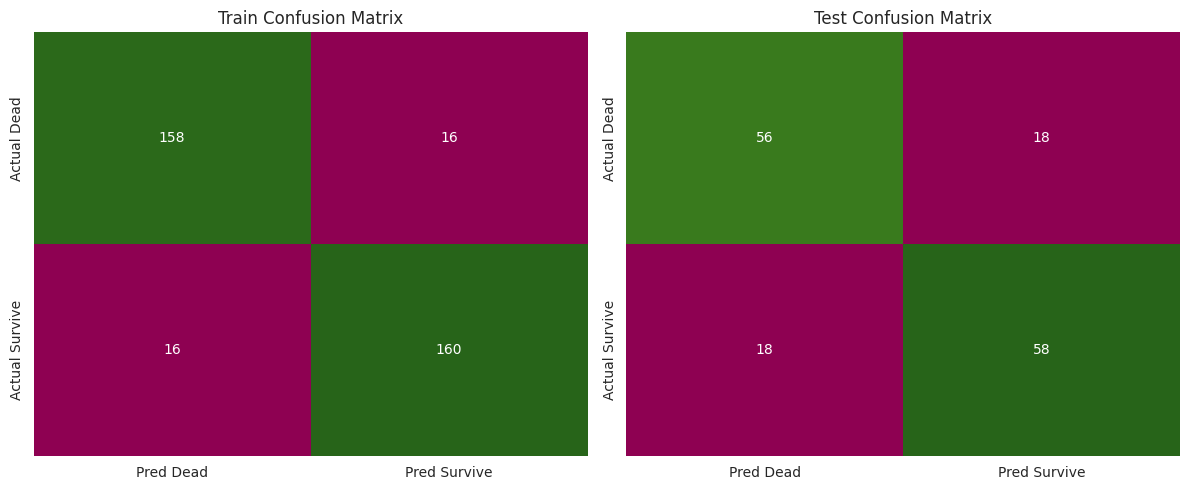

In [104]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test  = confusion_matrix(y_test,  y_pred_test)

# Side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="PiYG", cbar=False,
            xticklabels=["Pred Dead","Pred Survive"],
            yticklabels=["Actual Dead","Actual Survive"],
            ax=axes[0])
axes[0].set_title("Train Confusion Matrix")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="PiYG", cbar=False,
            xticklabels=["Pred Dead","Pred Survive"],
            yticklabels=["Actual Dead","Actual Survive"],
            ax=axes[1])
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

In [105]:
print(getattr(sv, "values", None).shape if hasattr(sv, "values") else type(sv))

(150, 11, 2)


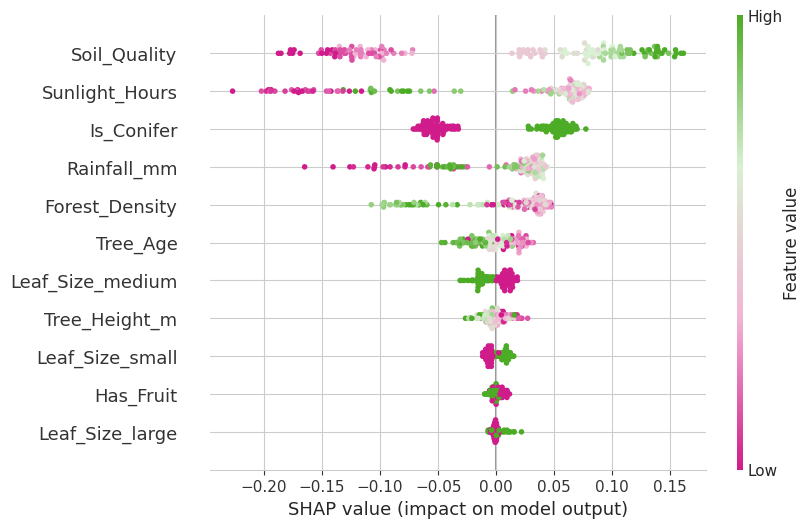

In [106]:
import numpy as np
import shap
import matplotlib.pyplot as plt

import shap
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'bubblegum_pistachio', ['#d01c8b', '#f2b4d4', '#d9f0d3', '#4dac26']
)

# ensure numeric inputs to SHAP
Xtr = X_train.astype(float)
Xte = X_test.astype(float)

explainer = shap.TreeExplainer(rf_best)
sv = explainer(Xte, check_additivity=False)

# pick the index of the positive class (label == 1)
pos_idx = int(np.where(rf_best.classes_ == 1)[0][0])

# reshape to single-output Explanation
if getattr(sv, "values", None) is not None and sv.values.ndim == 3:
    sv_pos = shap.Explanation(
        values        = sv.values[:, :, pos_idx],   # (n, features)
        base_values   = sv.base_values[:, pos_idx], # (n,)
        data          = sv.data,                    # (n, features)
        feature_names = sv.feature_names,
    )
else:
    sv_pos = sv  # already single-output

# plots
shap.plots.beeswarm(sv_pos, max_display=12,  color=cmap)
